## Датасеты

In [ ]:
!pip install awscli

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Скачивание датасета из исходной статьи

In [ ]:
!aws s3 sync --no-sign-request s3://openneuro.org/ds003688 ds003688-download/

In [ ]:
import os
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
import torch
import cv2
import numpy as np
from torchvision.transforms import ToTensor

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
cap = cv2.VideoCapture('Film stimulus.mp4') #from stimulus.rar
frames = []
to_tensor = ToTensor()
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret:# and len(frames) < 16*8:
    frame = cv2.resize(frame, (224,224),fx=0,fy=0, interpolation=cv2.INTER_CUBIC)
    frames.append(to_tensor(frame))
  else:
    break

# When everything done, release the video capture object
cap.release()

In [ ]:
class fMRIVideoDataset(Dataset):
  def __init__(self, mode='train', duration=2, skip_frames=1):
    self.duration = duration
    self.skip_frames = skip_frames
    #num fmri in one sample = 5*duration
    #num frames in one sample = 76*duration // skip_frames
    self.to_tensor = ToTensor()

    if mode == 'train':
      self.records = ['53', '41', '14', '16', '31', '08', '52', '22', '56', '43', '24', '15', '60', '13', '55', '45', '44', '07', '09', '46', '27']
      self.start_times = torch.arange(0, 641 - 10*duration, 5)
    elif mode == 'test':
      self.records = ['62', '29', '47', '18', '04', '51', '35', '11', '28']
      self.start_times = [641 - 5*duration]
    else:
      self.records = ['04', '07', '08', '09', '11', '13', '14', '15', '16', '18', '22', '24', '27', '28', '29', '31', '35', '41', '43', '44', '45', '46', '47', '51', '52', '53', '55', '56', '60', '62']
      self.start_times = torch.arange(0, 641 - duration * 5, 5)
     
  def __len__(self):
    return len(self.records) * len(self.start_times)

  def __getitem__(self, idx):
    idx_record = idx // len(self.start_times)
    idx_time = idx - idx_record
    start_time = self.start_times[idx_time] * 5
    start_frame = self.start_times[idx_time] * 76
    end_frame = start_frame + self.duration * 76
    #video = torch.Tensor(frames[start_frame:end_frame:self.skip_frames])
    video = frames[start_frame:end_frame:self.skip_frames]
    #video = video.permute(0, 3, 1, 2)
    position_idx = torch.arange(0, end_frame - start_frame, self.skip_frames)

    dir = 'ds003688-download/sub-{}/ses-mri3t/func'.format(self.records[idx_record])
    files = os.listdir(dir)
    for file in files:
      if file[-2:] == 'gz':
        nii_img  = nib.load(dir + '/' + file)
        nii_data = nii_img.get_fdata() #(40, 64, 64, 641)
        fmri = torch.Tensor(nii_data[:, :, :, start_time:start_time + self.duration * 5])
        fmri = fmri.permute(3, 0, 1, 2)
        return fmri, video, position_idx

In [ ]:
#example
dataset = fMRIVideoDataset(skip_frames=2)
fmri, video, position_idx = dataset[0]
fmri.shape, video.shape

### ещё один датасет (UCLA, использовался для обучения в статье TFF, там он назван CNP)

In [ ]:
!aws s3 sync --no-sign-request s3://openneuro.org/ds000030 ds000030-download/

Такс, ниже код предобработки сырого FMRI в voxel и global normalization представление.

Надо через нгео прогнать тензоры FMRI датасета из исходной статьи

In [ ]:
import os
import numpy as np
import nibabel as nib
import torch
from multiprocessing import Process, Queue

def preprocess(file_path, global_path, voxel_path): # nii.gz file
    """
        read nii.gz file from file_path
        save global and voxel norm to global_path, voxel_path
    """
    print(np.asanyarray(nib.load(file_path).dataobj).shape)
    img_orig = torch.from_numpy(np.asanyarray(nib.load(file_path).dataobj)[8:-8, 8:-8, :-10]).to(dtype=torch.float32)
    img_orig = img_orig.unsqueeze(-1) # add time dimension [W, H, D, T]
    background = img_orig == 0
    img_temp = (img_orig - img_orig[~background].mean()) / (img_orig[~background].std())
    img = torch.empty(img_orig.shape)
    img[background] = img_temp.min()
    img[~background] = img_temp[~background]
    img = torch.split(img, 1, 3)
    for i, TR in enumerate(img):
        torch.save(TR.clone(), os.path.join(global_path, 'globalr_fMRI_TR_' + str(i) + '.pt'))
    # repeat for per voxel normalization
    img_temp = (img_orig - img_orig.mean(dim=3, keepdims=True)) / (img_orig.std(dim=3, keepdims=True))
    img = torch.empty(img_orig.shape)
    img[background] = img_temp.min()
    img[~background] = img_temp[~background]
    img = torch.split(img, 1, 3)
    for i, TR in enumerate(img):
        torch.save(TR.clone(), os.path.join(voxel_path, 'voxel_rfMRI_TR_' + str(i) + '.pt'))
    print('finished another subject')


"""
ds_name = 'ds000030-download'
for subname in os.listdir(ds_name):
    if subname.startswith('sub'):
        folder = os.path.join(ds_name, subname, 'anat')
        if os.path.exists(folder):
            for scan in os.listdir(folder):
                if scan.endswith('nii.gz'):
                    file_path = os.path.join(folder, scan)
                    print(file_path)
                    preprocess(file_path, folder, folder)
"""

def preprocess_fmri(img_orig, global_path='', voxel_path=''):
    """
        save global and voxel norm to global_path, voxel_path
    """
    # img_orig = fmri_tensor.to(dtype=torch.float32).unsqueeze(-1) # add time dimension [W, H, D, T]
    background = img_orig == 0
    img_temp = (img_orig - img_orig[~background].mean()) / (img_orig[~background].std())
    img = torch.empty(img_orig.shape)
    img[background] = img_temp.min()
    img[~background] = img_temp[~background]
    img_global = img.detach().clone()
    img = torch.split(img, 1, 3)
    for i, TR in enumerate(img):
        print('global saving', i)
        torch.save(TR.clone(), os.path.join(global_path, 'global_fMRI_TR_' + str(i) + '.pt'))
    # repeat for per voxel normalization
    img_temp = (img_orig - img_orig.mean(dim=3, keepdims=True)) / (img_orig.std(dim=3, keepdims=True))
    img = torch.empty(img_orig.shape)
    img[background] = img_temp.min()
    img[~background] = img_temp[~background]
    img_voxel = img.detach().clone()
    img = torch.split(img, 1, 3)
    for i, TR in enumerate(img):
        print('voxel saving', i)
        torch.save(TR.clone(), os.path.join(voxel_path, 'voxel_rfMRI_TR_' + str(i) + '.pt'))
    print('finished another subject')
    return img_global, img_voxel

fmri_tensor = dataset[1][0].permute(1, 2, 3, 0) # [T, W, H, D]
print(fmri_tensor.shape)
g, v = preprocess_fmri(fmri_tensor, '', '')
g.shape, v.shape

torch.Size([40, 64, 64, 10])
global saving 0
global saving 1
global saving 2
global saving 3
global saving 4
global saving 5
global saving 6
global saving 7
global saving 8
global saving 9
voxel saving 0
voxel saving 1
voxel saving 2
voxel saving 3
voxel saving 4
voxel saving 5
voxel saving 6
voxel saving 7
voxel saving 8
voxel saving 9
finished another subject


(torch.Size([40, 64, 64, 10]), torch.Size([40, 64, 64, 10]))

In [ ]:
torch.stack([g, v]).shape

torch.Size([2, 40, 64, 64, 10])

In [ ]:
fmri_tensor.mean(), fmri_tensor.max(), fmri_tensor.min()

(tensor(198.5554), tensor(2270.2026), tensor(0.))

In [ ]:

# preprocessing

import os
import numpy as np
import nibabel as nib
import torch
from multiprocessing import Process, Queue


def read_hcp(file_path, global_norm_path, per_voxel_norm_path, hand, count, queue=None):
    img_orig = torch.from_numpy(np.asanyarray(nib.load(file_path).dataobj)[8:-8, 8:-8, :-10, 10:]).to(dtype=torch.float32)
    background = img_orig == 0
    img_temp = (img_orig - img_orig[~background].mean()) / (img_orig[~background].std())
    img = torch.empty(img_orig.shape)
    img[background] = img_temp.min()
    img[~background] = img_temp[~background]
    img = torch.split(img, 1, 3)
    for i, TR in enumerate(img):
        torch.save(TR.clone(),
                   os.path.join(global_norm_path, 'rfMRI_' + hand + '_TR_' + str(i) + '.pt'))
    # repeat for per voxel normalization
    img_temp = (img_orig - img_orig.mean(dim=3, keepdims=True)) / (img_orig.std(dim=3, keepdims=True))
    img = torch.empty(img_orig.shape)
    img[background] = img_temp.min()
    img[~background] = img_temp[~background]
    img = torch.split(img, 1, 3)
    for i, TR in enumerate(img):
        torch.save(TR.clone(),
                   os.path.join(per_voxel_norm_path, 'rfMRI_' + hand + '_TR_' + str(i) + '.pt'))
    print('finished another subject. count is now {}'.format(count))

def main():
    hcp_path = r'D:\users\Gony\HCP-1200'
    all_files_path = os.path.join(hcp_path,'extract_S1200_data')
    queue = Queue()
    count = 0
    for subj in os.listdir(all_files_path):
        subj_path = os.path.join(all_files_path,subj)
        try:
            file_path = os.path.join(subj_path,os.listdir(subj_path)[0])
            hand = file_path[file_path.find('REST1_')+6:file_path.find('.nii')]
            global_norm_path = os.path.join(hcp_path,'MNI_to_TRs',subj,'global_normalize')
            per_vox_norm_path = os.path.join(hcp_path, 'MNI_to_TRs', subj, 'per_voxel_normalize')
            os.makedirs(global_norm_path, exist_ok=True)
            os.makedirs(per_vox_norm_path, exist_ok=True)
            count += 1
            print('start working on subject '+ subj)
            p = Process(target=read_hcp, args=(file_path,global_norm_path,per_vox_norm_path,hand,count, queue))
            p.start()
            if count % 20 == 0:
                p.join()  # this blocks until the process terminates
        except Exception:
            print('encountered problem with '+subj)
            print(Exception)
if __name__ == '__main__':
    main()

## репозиторий из статьи TFF

In [ ]:
!git clone https://github.com/GonyRosenman/TFF

Cloning into 'TFF'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 135 (delta 62), reused 86 (delta 34), pack-reused 17
Receiving objects: 100% (135/135), 687.96 KiB | 10.42 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [ ]:
%cd TFF

/content/TFF


In [ ]:
!ls

augmentations.py	  losses.py	  model.py	    test.py
data			  loss_writer.py  nvidia_blocks.py  trainer.py
data_preprocess_and_load  main.py	  readme.md	    utils.py
learning_rate.py	  metrics.py	  requirements.txt


In [ ]:
!pip install transformers

In [ ]:
!python main.py --dataset_name S1200 --fine_tune_task binary_classification

starting phase 1...
Traceback (most recent call last):
  File "main.py", line 134, in <module>
    main(base_path)
  File "main.py", line 116, in main
    model_weights_path_phase1 = run_phase(args,None,'1','autoencoder_reconstruction')
  File "main.py", line 96, in run_phase
    trainer = Trainer(sets=S,**args)
  File "/content/TFF/trainer.py", line 18, in __init__
    self.train_loader, self.val_loader, _ = DataHandler(**kwargs).create_dataloaders()
  File "/content/TFF/data_preprocess_and_load/dataloaders.py", line 30, in create_dataloaders
    train_loader = dataset(**self.kwargs)
  File "/content/TFF/data_preprocess_and_load/datasets.py", line 69, in __init__
    self.subject_names = os.listdir(self.data_dir)
FileNotFoundError: [Errno 2] No such file or directory: 'D:\\users\\Gony\\HCP-1200/MNI_to_TRs'


### Тут я просто вставляю код из статьи TFF

In [ ]:
# datasets.py

import os
import torch
from torch.utils.data import Dataset
import augmentations
import pandas as pd
from pathlib import Path


class BaseDataset(Dataset):
    def __init__(self):
        super().__init__()
    def register_args(self, **kwargs):
        #todo:decide if keep immedieate load or not
        self.device = None #torch.device('cuda') if kwargs.get('cuda') else torch.device('cpu')
        self.index_l = []
        self.norm = 'global_normalize'
        self.complementary = 'per_voxel_normalize'
        self.random_TR = kwargs.get('random_TR')
        # self.set_augmentations(**kwargs)
        self.stride_factor = 1
        self.sequence_stride = 1
        self.sequence_length = kwargs.get('sequence_length')
        self.sample_duration = self.sequence_length * self.sequence_stride
        self.stride = max(round(self.stride_factor * self.sample_duration),1)
        self.TR_skips = range(0, self.sample_duration, self.sequence_stride)

    def get_input_shape(self):
        shape = torch.load(os.path.join(self.index_l[0][2],self.index_l[0][3] + '.pt')).squeeze().shape
        return shape

    def set_augmentations(self,**kwargs):
        if kwargs.get('augment_prob') > 0:
            self.augment = augmentations.brain_gaussian(**kwargs)
        else:
            self.augment = None

    def TR_string(self, filename_TR, x):
        # all datasets should have the TR mentioned in the format of 'some prefix _ number.pt'
        TR_num = [xx for xx in filename_TR.split('_') if xx.isdigit()][0]
        assert len(filename_TR.split('_')) == 2
        filename = filename_TR.replace(TR_num,str(int(TR_num) + x)) + '.pt'
        return filename

    def determine_TR(self, TRs_path, TR):
        if self.random_TR:
            possible_TRs = len(os.listdir(TRs_path)) - self.sample_duration
            TR = 'TR_' + str(torch.randint(0,possible_TRs,(1,)).item())
        return TR

    def load_sequence(self, TRs_path, TR):
        """
        the logic of this function is that always
        the first channel corresponds to global norm
        and if there is a second channel it belongs to per voxel.
        """
        TR = self.determine_TR(TRs_path, TR)
        y = torch.cat([torch.load(os.path.join(TRs_path, self.TR_string(TR, x)), map_location=self.device).unsqueeze(0)
                        for x in self.TR_skips], dim=4)
        if self.complementary is not None:
            y1 = torch.cat([torch.load(os.path.join(TRs_path, self.TR_string(TR, x)).replace(self.norm, self.complementary),
                            map_location=self.device).unsqueeze(0)
                            for x in self.TR_skips], dim=4)
            y1[y1 != y1] = 0
            y = torch.cat([y, y1], dim=0)
            del y1
        return y

class rest_1200_3D(BaseDataset):
    def __init__(self, **kwargs):
        self.register_args(**kwargs)
        # self.root = r'D:\users\Gony\HCP-1200'
        self.root = ''
        self.meta_data = pd.read_csv(os.path.join(kwargs.get('base_path'),'data','metadata','HCP_1200_gender.csv'))
        self.meta_data_residual = pd.read_csv(os.path.join(kwargs.get('base_path'),'data','metadata','HCP_1200_precise_age.csv'))
        self.data_dir = os.path.join(self.root, 'MNI_to_TRs')
        self.subject_names = os.listdir(self.data_dir)
        self.label_dict = {'F': torch.tensor([0.0]), 'M': torch.tensor([1.0]), '22-25': torch.tensor([1.0, 0.0]),
                           '26-30': torch.tensor([1.0, 0.0]),
                           '31-35': torch.tensor([0.0, 1.0]), '36+': torch.tensor([0.0, 1.0])}  # torch.tensor([1])}
        self.subject_folders = []
        for i, subject in enumerate(os.listdir(self.data_dir)):
            try:
                age = torch.tensor(self.meta_data_residual[self.meta_data_residual['subject']==int(subject)]['age'].values[0])
            except Exception:
                #deal with discrepency that a few subjects don't have exact age, so we take the mean of the age range as the exact age proxy
                age = self.meta_data[self.meta_data['Subject'] == int(subject)]['Age'].values[0]
                age = torch.tensor([float(x) for x in age.replace('+','-').split('-')]).mean()
            gender = self.meta_data[self.meta_data['Subject']==int(subject)]['Gender'].values[0]
            path_to_TRs = os.path.join(self.data_dir,subject,self.norm)
            subject_duration = len(os.listdir(path_to_TRs))#121
            session_duration = subject_duration - self.sample_duration
            filename = os.listdir(path_to_TRs)[0]
            filename = filename[:filename.find('TR')+3]

            for k in range(0,session_duration,self.stride):
                self.index_l.append((i, subject, path_to_TRs,filename + str(k),session_duration, age , gender))

    def __len__(self):
        N = len(self.index_l)
        return N

    def __getitem__(self, index):
        subj, subj_name, path_to_TRs, TR, session_duration, age, gender = self.index_l[index]
        age = self.label_dict[age] if isinstance(age,str) else age.float()
        y = self.load_sequence(path_to_TRs, TR)
        if self.augment is not None:
            y = self.augment(y)
        return {
            'fmri_sequence': y,
            'subject': subj,
            'subject_binary_classification': self.label_dict[gender],
            'subject_regression': age,
            'TR': int(TR.split('_')[1])
        }


class ucla(BaseDataset):
    def __init__(self, **kwargs):
        super(ucla, self).__init__()
        self.register_args(**kwargs)
        datasets_folder = str(Path(kwargs.get('base_path')).parent.parent)
        self.root = os.path.join(datasets_folder,'fmri_data','ucla','ucla','output')
        self.meta_data = pd.read_csv(os.path.join(kwargs.get('base_path'),'data','metadata','ucla_participants.tsv'),sep='\t')
        self.data_dir = os.path.join(self.root, 'rest')
        self.subjects = len(os.listdir(self.data_dir))
        self.subjects_names = os.listdir(self.data_dir)
        for i, subject in enumerate(self.subjects_names):
            try:
                diagnosis = self.meta_data.loc[self.meta_data['participant_id'] == subject, ['diagnosis']].values[0][0]
            except Exception as e:
                print(e)
            TRs_path = os.path.join(self.data_dir, subject,self.norm)
            session_duration = len(os.listdir(TRs_path)) - self.sample_duration
            diagnosis = torch.tensor([0.0]) if diagnosis == 'CONTROL' else torch.tensor([1.0])
            #TODO:debug
            #diagnosis = torch.tensor([1.0, 0.0]) if diagnosis == 'CONTROL' else torch.tensor([0.0, 1.0])
            for k in range(0, session_duration, self.stride):
                self.index_l.append((i, subject, TRs_path, 'TR_' + str(k), session_duration, diagnosis ))


    def __len__(self):
        N = len(self.index_l)
        return N

    def __getitem__(self, index):
        subj_num, subj_name, TRs_path, TR, session_duration, diagnosis = self.index_l[index]
        y = self.load_sequence(TRs_path, TR)
        if self.augment is not None:
            y = self.augment(y)
        input_dict = {
            'fmri_sequence': y,
            'subject': subj_num,
            'subject_binary_classification': diagnosis,
            'TR': int(TR.split('_')[1])
        }
        return input_dict

class ptsd(BaseDataset):
    def __init__(self, **kwargs):
        self.register_args(**kwargs)
        self.sessions = ['ses-1','ses-2','ses-3']
        self.root = r'D:\users\Gony\ptsd\ziv'
        self.meta_data = pd.read_csv(os.path.join(self.root, 'caps.csv'))
        self.data_dir = os.path.join(self.root, 'MNI_to_TRs')
        self.subject_names = os.listdir(self.data_dir)
        self.subjects = len(os.listdir(self.data_dir))
        self.index_l = []
        for i,subject in enumerate(os.listdir(self.data_dir)):
            for session in os.listdir(os.path.join(self.data_dir,subject)):
                for task in os.listdir(os.path.join(self.data_dir, subject,session)):
                    ses = str(session[session.find('-')+1])
                    category1 = "T" + ses + "_TotalCaps4'"
                    category2 = "T" + ses + "_TotalCaps5'"
                    category3 = "T" + ses + "_Is PTSD_Final"
                    score = self.meta_data.loc[self.meta_data['Subject ID'] == int(subject[-4:]),[category1,category2,category3]].values.tolist()[0]
                    TRs_path = os.path.join(self.data_dir, subject,session,task, self.norm_name)
                    session_duration = len(os.listdir(TRs_path)) - self.sample_duration
                    for k in range(0,session_duration, self.stride):
                        if not any(np.isnan(score)):
                            self.index_l.append((i, subject[-4:], TRs_path, 'TR_' + str(k), session_duration, (task, session, score[0], score[1], score[2])))
        if not self.fine_tune:
            extra_data = self.data_dir.replace('ziv','tom')
            for j,subj in enumerate(os.listdir(extra_data)):
                for time in os.listdir(os.path.join(extra_data,subj)):
                    for session in os.listdir(os.path.join(extra_data,subj,time)):
                        for task in os.listdir(os.path.join(extra_data,subj,time,session)):
                            path_to_TRs = os.path.join(extra_data,subj,time,session,task,self.norm_name)
                            session_duration = len(os.listdir(path_to_TRs)) - self.sample_duration
                            for k in range(0,session_duration,self.stride):
                                self.index_l.append((j+i,subj,path_to_TRs, 'TR_' + str(k), session_duration, (task,session,np.nan,np.nan,np.nan)))
            extra_data = self.data_dir.replace(r'ptsd\ziv','ayam')
            for k, subject in enumerate(os.listdir(extra_data)):
                for task in os.listdir(os.path.join(extra_data, subject)):
                    TRs_path = os.path.join(extra_data, subject, task, self.norm_name)
                    session_duration = len(os.listdir(TRs_path)) - self.sample_duration
                    for kk in range(0, session_duration, self.stride):
                        self.index_l.append((k, subject, TRs_path, 'TR_' + str(kk), session_duration, (task,np.nan, np.nan, np.nan, np.nan)))

    def __len__(self):
        N = len(self.index_l)
        return N

    def __getitem__(self, index):
        subj_num, subj_name, TRs_path, TR, session_duration, diagnosis = self.index_l[index]
        y = self.load_sequence(TRs_path, TR)
        if self.augment is not None:
            y = self.augment(y)
        input_dict = {
            'fmri_sequence': y,
            'subject': subj_num,
            'subject_binary_classification': diagnosis ,
            'TR': int(TR.split('_')[1])
        }
        return input_dict

class myDataset(BaseDataset):
    def __init__(self, **kwargs):
        self.register_args(**kwargs)

    def __len__(self):
        return len(fmri_video_dataset) # global

    def __getitem__(self, index):
        fmri = fmri_video_dataset[index][0].permute(1, 2, 3, 0) # [T, W, H, D]
        g, v = preprocess_fmri(fmri)
        y = torch.stack([g, v])
        print('y', y.shape, g.shape, v.shape)
        return {
            'fmri_sequence': y # [2, W, H, D, T] tensor
        }
    

fmri_video_dataset = fMRIVideoDataset(skip_frames=2)
my_dataset = myDataset(sequence_length=0)
my_dataset[0]

ModuleNotFoundError: ignored

In [ ]:
# dataloaders 
import numpy as np
from torch.utils.data import DataLoader, Subset
from data_preprocess_and_load.datasets import *
from utils import reproducibility
import json

class DataHandler():
    def __init__(self,test=False,**kwargs):
        self.test = test
        self.kwargs = kwargs
        self.dataset_name = kwargs.get('dataset_name')
        self.splits_folder = Path(kwargs.get('base_path')).joinpath('splits',self.dataset_name)
        self.splits_folder.mkdir(exist_ok=True)
        self.seed = kwargs.get('seed')
        self.current_split = self.splits_folder.joinpath('seed_{}.txt'.format(self.seed))

    def get_dataset(self):
        if self.dataset_name == 'S1200':
            return rest_1200_3D
        elif self.dataset_name == 'ucla':
            return ucla
        elif self.dataset_name == 'myDataset':
            return myDataset
        else:
            raise NotImplementedError

    def current_split_exists(self):
        return self.current_split.exists()

    def create_dataloaders(self):
        reproducibility(**self.kwargs)
        dataset = self.get_dataset()
        for key, val in self.kwargs.items():
            print(key, val)
        train_loader = dataset(**self.kwargs)
        eval_loader = dataset(**self.kwargs)
        eval_loader.augment = None

        self.subject_list = train_loader.index_l
        if self.current_split_exists():
            train_names, val_names, test_names = self.load_split()
            train_idx, val_idx, test_idx = self.convert_subject_list_to_idx_list(train_names,val_names,test_names,self.subject_list)
        else:
            train_idx, val_idx, test_idx = self.determine_split_randomly(self.subject_list,**self.kwargs)

        # train_idx = [train_idx[x] for x in torch.randperm(len(train_idx))[:10]]
        # val_idx = [val_idx[x] for x in torch.randperm(len(val_idx))[:10]]

        train_loader = Subset(train_loader, train_idx)
        val_loader = Subset(eval_loader, val_idx)
        test_loader = Subset(eval_loader, test_idx)

        training_generator = DataLoader(train_loader, **self.get_params(**self.kwargs))
        val_generator = DataLoader(val_loader, **self.get_params(eval=True,**self.kwargs))
        test_generator = DataLoader(test_loader, **self.get_params(eval=True,**self.kwargs))  if self.test else None
        return training_generator, val_generator, test_generator


    def get_params(self,eval=False,**kwargs):
        batch_size = kwargs.get('batch_size')
        workers = kwargs.get('workers')
        cuda = kwargs.get('cuda')
        if eval:
            workers = 0
        params = {'batch_size': batch_size,
                  'shuffle': True,
                  'num_workers': workers,
                  'drop_last': True,
                  'pin_memory': False,  # True if cuda else False,
                  'persistent_workers': True if workers > 0 and cuda else False}
        return params

    def save_split(self,sets_dict):
        with open(self.current_split,'w+') as f:
            for name,subj_list in sets_dict.items():
                f.write(name + '\n')
                for subj_name in subj_list:
                    f.write(str(subj_name) + '\n')

    def convert_subject_list_to_idx_list(self,train_names,val_names,test_names,subj_list):
        subj_idx = np.array([str(x[0]) for x in subj_list])
        train_idx = np.where(np.in1d(subj_idx, train_names))[0].tolist()
        val_idx = np.where(np.in1d(subj_idx, val_names))[0].tolist()
        test_idx = np.where(np.in1d(subj_idx, test_names))[0].tolist()
        return train_idx,val_idx,test_idx

    def determine_split_randomly(self,index_l,**kwargs):
        train_percent = kwargs.get('train_split')
        val_percent = kwargs.get('val_split')
        S = len(np.unique([x[0] for x in index_l]))
        S_train = int(S * train_percent)
        S_val = int(S * val_percent)
        S_train = np.random.choice(S, S_train, replace=False)
        remaining = np.setdiff1d(np.arange(S), S_train)
        S_val = np.random.choice(remaining,S_val, replace=False)
        S_test = np.setdiff1d(np.arange(S), np.concatenate([S_train,S_val]))
        train_idx,val_idx,test_idx = self.convert_subject_list_to_idx_list(S_train,S_val,S_test,self.subject_list)
        self.save_split({'train_subjects':S_train,'val_subjects':S_val,'test_subjects':S_test})
        return train_idx,val_idx,test_idx

    def load_split(self):
        subject_order = open(self.current_split, 'r').readlines()
        subject_order = [x[:-1] for x in subject_order]
        train_index = np.argmax(['train' in line for line in subject_order])
        val_index = np.argmax(['val' in line for line in subject_order])
        test_index = np.argmax(['test' in line for line in subject_order])
        train_names = subject_order[train_index + 1:val_index]
        val_names = subject_order[val_index+1:test_index]
        test_names = subject_order[test_index + 1:]
        return train_names,val_names,test_names

In [ ]:
# trainer.py

from loss_writer import Writer
from learning_rate import LrHandler
from data_preprocess_and_load.dataloaders import DataHandler
import torch
import warnings
from tqdm import tqdm
from model import Encoder_Transformer_Decoder,Encoder_Transformer_finetune,AutoEncoder
from losses import get_intense_voxels

class Trainer():
    """
    main class to handle training, validation and testing.
    note: the order of commands in the constructor is necessary
    """
    def __init__(self,sets,**kwargs):
        self.register_args(**kwargs)
        self.lr_handler = LrHandler(**kwargs)
        self.train_loader, self.val_loader, _ = DataHandler(**kwargs).create_dataloaders()
        self.create_model()
        self.initialize_weights(load_cls_embedding=False)
        self.create_optimizer()
        self.lr_handler.set_schedule(self.optimizer)
        self.writer = Writer(sets,**kwargs)
        self.sets = sets
        self.eval_iter = 0

        for name, loss_dict in self.writer.losses.items():
            if loss_dict['is_active']:
                print('using {} loss'.format(name))
                setattr(self, name + '_loss_func', loss_dict['criterion'])

    def create_optimizer(self):
        lr = self.lr_handler.base_lr
        params = self.model.parameters()
        weight_decay = self.kwargs.get('weight_decay')
        self.optimizer = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)

    def initialize_weights(self,load_cls_embedding):
        if self.loaded_model_weights_path is not None:
            state_dict = torch.load(self.loaded_model_weights_path)
            self.lr_handler.set_lr(state_dict['lr'])
            self.model.load_partial_state_dict(state_dict['model_state_dict'],load_cls_embedding)
            self.model.loaded_model_weights_path = self.loaded_model_weights_path
            text = 'loaded model weights:\nmodel location - {}\nlast learning rate - {}\nvalidation loss - {}\n'.format(
                self.loaded_model_weights_path, state_dict['lr'],state_dict['loss_value'])
            if 'accuracy' in state_dict:
                text += 'validation accuracy - {}'.format(state_dict['accuracy'])
            print(text)

    def create_model(self):
        dim = self.train_loader.dataset.dataset.get_input_shape()
        if self.task.lower() == 'fine_tune':
            self.model = Encoder_Transformer_finetune(dim,**self.kwargs)
        elif self.task.lower() == 'autoencoder_reconstruction':
            self.model = AutoEncoder(dim,**self.kwargs)
        elif self.task.lower() == 'transformer_reconstruction':
            self.model = Encoder_Transformer_Decoder(dim,**self.kwargs)
        if self.cuda:
            self.model = self.model.cuda()

    def eval_epoch(self,set):
        loader = self.val_loader if set == 'val' else self.test_loader
        self.eval(set)
        with torch.no_grad():
            for input_dict in tqdm(loader, position=0, leave=True):
                loss_dict, _ = self.forward_pass(input_dict)
                self.writer.write_losses(loss_dict, set=set)


    def testing(self):
        self.eval_epoch('test')
        self.writer.loss_summary(lr=0)
        self.writer.accuracy_summary(mid_epoch=False)
        for metric_name in dir(self.writer):
            if 'history' not in metric_name:
                continue
            metric_score = getattr(self.writer,metric_name)[-1]
            print('final test score - {} = {}'.format(metric_name,metric_score))


    def training(self):
        for epoch in range(self.nEpochs):
            self.train_epoch(epoch)
            self.eval_epoch('val')
            print('______epoch summary {}/{}_____\n'.format(epoch+1,self.nEpochs))
            self.writer.loss_summary(lr=self.lr_handler.schedule.get_last_lr()[0])
            self.writer.accuracy_summary(mid_epoch=False)
            self.writer.save_history_to_csv()
            self.save_checkpoint_(epoch)


    def train_epoch(self,epoch):
        self.train()
        for batch_idx,input_dict in enumerate(tqdm(self.train_loader,position=0,leave=True)):
            self.writer.total_train_steps += 1
            self.optimizer.zero_grad()
            loss_dict, loss = self.forward_pass(input_dict)
            loss.backward()
            self.optimizer.step()
            self.lr_handler.schedule_check_and_update()
            self.writer.write_losses(loss_dict, set='train')
            if (batch_idx + 1) % self.validation_frequency == 0:
                partial_epoch = epoch + (batch_idx / len(self.train_loader))
                self.eval_epoch('val')
                print('______mid-epoch summary {0:.2f}/{1:.0f}______\n'.format(partial_epoch,self.nEpochs))
                self.writer.loss_summary(lr=self.lr_handler.schedule.get_last_lr()[0])
                self.writer.accuracy_summary(mid_epoch=True)
                self.writer.save_history_to_csv()
                self.save_checkpoint_(partial_epoch)
                self.train()


    def eval(self,set):
        self.mode = set
        self.model = self.model.eval()

    def train(self):
        self.mode = 'train'
        self.model = self.model.train()

    def get_last_loss(self):
        if self.model.task == 'regression':
            return self.writer.val_MAE[-1]
        else:
            return self.writer.total_val_loss_history[-1]

    def get_last_accuracy(self):
        if hasattr(self.writer,'val_AUROC'):
            return self.writer.val_AUROC[-1]
        else:
            return None

    def save_checkpoint_(self,epoch):
        loss = self.get_last_loss()
        accuracy = self.get_last_accuracy()
        self.model.save_checkpoint(
            self.writer.experiment_folder, self.writer.experiment_title, epoch, loss ,accuracy, self.optimizer ,schedule=self.lr_handler.schedule)


    def forward_pass(self,input_dict):
        input_dict = {k:(v.cuda() if self.cuda else v) for k,v in input_dict.items()}
        output_dict = self.model(input_dict['fmri_sequence'])
        loss_dict, loss = self.aggregate_losses(input_dict, output_dict)
        if self.task == 'fine_tune':
            self.compute_accuracy(input_dict, output_dict)
        return loss_dict, loss


    def aggregate_losses(self,input_dict,output_dict):
        final_loss_dict = {}
        final_loss_value = 0
        for loss_name, current_loss_dict in self.writer.losses.items():
            if current_loss_dict['is_active']:
                loss_func = getattr(self, 'compute_' + loss_name)
                current_loss_value = loss_func(input_dict,output_dict)
                if current_loss_value.isnan().sum() > 0:
                    warnings.warn('found nans in computation')
                    print('at {} loss'.format(loss_name))
                lamda = current_loss_dict['factor']
                factored_loss = current_loss_value * lamda
                final_loss_dict[loss_name] = factored_loss.item()
                final_loss_value += factored_loss
        final_loss_dict['total'] = final_loss_value.item()
        return final_loss_dict, final_loss_value

    def compute_reconstruction(self,input_dict,output_dict):
        fmri_sequence = input_dict['fmri_sequence'][:,0].unsqueeze(1)
        reconstruction_loss = self.reconstruction_loss_func(output_dict['reconstructed_fmri_sequence'],fmri_sequence)
        return reconstruction_loss

    def compute_intensity(self,input_dict,output_dict):
        per_voxel = input_dict['fmri_sequence'][:,1,:,:,:,:]
        voxels = get_intense_voxels(per_voxel, output_dict['reconstructed_fmri_sequence'].shape)
        output_intense = output_dict['reconstructed_fmri_sequence'][voxels]
        truth_intense = input_dict['fmri_sequence'][:,0][voxels.squeeze(1)]
        intensity_loss = self.intensity_loss_func(output_intense.squeeze(), truth_intense)
        return intensity_loss

    def compute_perceptual(self,input_dict,output_dict):
        fmri_sequence = input_dict['fmri_sequence'][:,0].unsqueeze(1)
        perceptual_loss = self.perceptual_loss_func(output_dict['reconstructed_fmri_sequence'],fmri_sequence)
        return perceptual_loss

    def compute_binary_classification(self,input_dict,output_dict):
        binary_loss = self.binary_classification_loss_func(output_dict['binary_classification'].squeeze(), input_dict['subject_binary_classification'].squeeze())
        return binary_loss

    def compute_regression(self,input_dict,output_dict):
        gender_loss = self.regression_loss_func(output_dict['regression'].squeeze(),input_dict['subject_regression'].squeeze())
        return gender_loss

    def compute_accuracy(self,input_dict,output_dict):
        task = self.model.task
        out = output_dict[task].detach().clone().cpu()
        score = out.squeeze() if out.shape[0] > 1 else out
        labels = input_dict['subject_' + task].clone().cpu()
        subjects = input_dict['subject'].clone().cpu()
        for i, subj in enumerate(subjects):
            subject = str(subj.item())
            if subject not in self.writer.subject_accuracy:
                self.writer.subject_accuracy[subject] = {'score': score[i].unsqueeze(0), 'mode': self.mode, 'truth': labels[i],'count': 1}
            else:
                self.writer.subject_accuracy[subject]['score'] = torch.cat([self.writer.subject_accuracy[subject]['score'], score[i].unsqueeze(0)], dim=0)
                self.writer.subject_accuracy[subject]['count'] += 1

    def register_args(self,**kwargs):
        for name,value in kwargs.items():
            setattr(self,name,value)
        self.kwargs = kwargs




In [ ]:
%%writefile utils.py

from data_preprocess_and_load.datasets import *
import numpy as np
import torch
import torch.backends.cudnn as cudnn
from datetime import datetime
import argparse
import os
import dill

def datestamp():
    time = datetime.now().strftime("%d_%m___%H_%M_%S")
    return time

def reproducibility(**kwargs):
    seed = kwargs.get('seed')
    cuda = kwargs.get('cuda')
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    cudnn.deterministic = True
    cudnn.benchmark = True

def sort_args(phase, args):
    phase_specific_args = {}
    for name, value in args.items():
        if not 'phase' in name:
            phase_specific_args[name] = value
        elif 'phase' + phase in name:
            phase_specific_args[name.replace('_phase' + phase, '')] = value
    return phase_specific_args

def args_logger(args):
    args_to_pkl(args)
    args_to_text(args)


def args_to_pkl(args):
    with open(os.path.join(args.experiment_folder,'arguments_as_is.pkl'),'wb') as f:
        dill.dump(vars(args),f)

def args_to_text(args):
    with open(os.path.join(args.experiment_folder,'argument_documentation.txt'),'w+') as f:
        for name,arg in vars(args).items():
            f.write('{}: {}\n'.format(name,arg))


Overwriting utils.py


In [ ]:
# main

from utils import *
from trainer import Trainer
import os
from pathlib import Path

def get_arguments(base_path):
    """
    handle arguments from commandline.
    some other hyper parameters can only be changed manually (such as model architecture,dropout,etc)
    notice some arguments are global and take effect for the entire three phase training process, while others are determined per phase
    """
    parser = argparse.ArgumentParser()
    parser.add_argument('--base_path', default=base_path)
    parser.add_argument('--seed', type=int, default=55555555)
    parser.add_argument('--dataset_name', type=str, default="ucla")
    parser.add_argument('--cuda', default=True)
    parser.add_argument('--log_dir', type=str, default=os.path.join(base_path, 'runs'))
    parser.add_argument('--random_TR', default=True)
    parser.add_argument('--intensity_factor', default=1)
    parser.add_argument('--perceptual_factor', default=1)
    parser.add_argument('--reconstruction_factor', default=1)
    parser.add_argument('--transformer_hidden_layers', default=2)
    parser.add_argument('--fine_tune_task',
                        default='binary_classification',
                        choices=['regression','binary_classification'],
                        help='fine tune model objective. choose binary_classification in case of a binary classification task')
    parser.add_argument('--train_split', default=0.7)
    parser.add_argument('--val_split', default=0.15)
    parser.add_argument('--running_mean_size', default=5000)


    ##phase 1
    parser.add_argument('--task_phase1', type=str, default='autoencoder_reconstruction')
    parser.add_argument('--batch_size_phase1', type=int, default=4)
    parser.add_argument('--validation_frequency_phase1', type=int, default=1000)
    parser.add_argument('--nEpochs_phase1', type=int, default=10)
    parser.add_argument('--augment_prob_phase1', default=0)
    parser.add_argument('--weight_decay_phase1', default=1e-7)
    parser.add_argument('--lr_init_phase1', default=1e-3)
    parser.add_argument('--lr_gamma_phase1', default=0.97)
    parser.add_argument('--lr_step_phase1', default=500)
    parser.add_argument('--sequence_length_phase1', default=1)
    parser.add_argument('--workers_phase1', default=4)

    ##phase 2
    parser.add_argument('--task_phase2', type=str, default='transformer_reconstruction')
    parser.add_argument('--batch_size_phase2', type=int, default=1)
    parser.add_argument('--validation_frequency_phase2', type=int, default=500)
    parser.add_argument('--nEpochs_phase2', type=int, default=5)
    parser.add_argument('--augment_prob_phase2', default=0)
    parser.add_argument('--weight_decay_phase2', default=1e-7)
    parser.add_argument('--lr_gamma_phase2', default=0.97)
    parser.add_argument('--lr_step_phase2', default=1000)
    parser.add_argument('--sequence_length_phase2', default=20)
    parser.add_argument('--workers_phase2', default=1)

    ##phase 3
    parser.add_argument('--task_phase3', type=str, default='fine_tune')
    parser.add_argument('--batch_size_phase3', type=int, default=3)
    parser.add_argument('--validation_frequency_phase3', type=int, default=200)
    parser.add_argument('--nEpochs_phase3', type=int, default=30)
    parser.add_argument('--augment_prob_phase3', default=0)
    parser.add_argument('--weight_decay_phase3', default=1e-2)
    parser.add_argument('--lr_init_phase3', default=1e-4)
    parser.add_argument('--lr_gamma_phase3', default=0.9)
    parser.add_argument('--lr_step_phase3', default=1500)
    parser.add_argument('--sequence_length_phase3', default=20)
    parser.add_argument('--workers_phase3', default=0)
    args = parser.parse_args()
    return args

def setup(cuda_num):
    cuda_num = str(cuda_num)
    os.environ["CUDA_VISIBLE_DEVICES"] = cuda_num
    base_path = os.getcwd()
    os.makedirs(os.path.join(base_path,'experiments'),exist_ok=True)
    os.makedirs(os.path.join(base_path,'runs'),exist_ok=True)
    os.makedirs(os.path.join(base_path, 'splits'), exist_ok=True)
    return base_path

def run_phase(args,loaded_model_weights_path,phase_num,phase_name):
    """
    main process that runs each training phase
    :return path to model weights (pytorch file .pth) aquried by the current training phase
    """
    experiment_folder = '{}_{}_{}'.format(args.dataset_name,phase_name,datestamp())
    experiment_folder = Path(os.path.join(args.base_path,'experiments',experiment_folder))
    os.makedirs(experiment_folder)
    setattr(args,'loaded_model_weights_path_phase' + phase_num,loaded_model_weights_path)
    args.experiment_folder = experiment_folder
    args.experiment_title = experiment_folder.name
    fine_tune_task = args.fine_tune_task
    args_logger(args)
    args = sort_args(phase_num, vars(args))
    S = ['train','val']
    trainer = Trainer(sets=S,**args)
    trainer.training()
    if phase_num == '3' and not fine_tune_task == 'regression':
        critical_metric = 'accuracy'
    else:
        critical_metric = 'loss'
    model_weights_path = os.path.join(trainer.writer.experiment_folder,trainer.writer.experiment_title + '_BEST_val_{}.pth'.format(critical_metric))
    return model_weights_path

def test(args,model_weights_path):
    experiment_folder = '{}_{}_{}'.format(args.dataset_name, 'test_{}'.format(args.fine_tune_task), datestamp())
    experiment_folder = os.path.join(args.base_path,'tests', experiment_folder)
    os.makedirs(experiment_folder)
    trainer = Trainer(experiment_folder, '3', args, ['test'], model_weights_path)
    trainer.testing()

def main(base_path):
    args = get_arguments(base_path)
    # pretrain step1
    print('starting phase 1...')
    model_weights_path_phase1 = run_phase(args,None,'1','autoencoder_reconstruction')
    print('finishing phase 1...')
    #pretrain step2
    print('starting phase 2...')
    model_weights_path_phase2 = run_phase(args,model_weights_path_phase1, '2', 'tranformer_reconstruction')
    print('finishing phase 2...')
    #fine tune
    print('starting phase 3...')
    model_weights_path_phase3 = run_phase(args, model_weights_path_phase2,'3','fine_tune_{}'.format(args.fine_tune_task))
    print('finishing phase 3...')
    #test
    test(args, model_weights_path_phase3)


if __name__ == '__main__':
    # base_path = setup(cuda_num=0)
    print(base_path)
    main(base_path)



/content


usage: ipykernel_launcher.py [-h] [--base_path BASE_PATH] [--seed SEED]
                             [--dataset_name DATASET_NAME] [--cuda CUDA]
                             [--log_dir LOG_DIR] [--random_TR RANDOM_TR]
                             [--intensity_factor INTENSITY_FACTOR]
                             [--perceptual_factor PERCEPTUAL_FACTOR]
                             [--reconstruction_factor RECONSTRUCTION_FACTOR]
                             [--transformer_hidden_layers TRANSFORMER_HIDDEN_LAYERS]
                             [--fine_tune_task {regression,binary_classification}]
                             [--train_split TRAIN_SPLIT]
                             [--val_split VAL_SPLIT]
                             [--running_mean_size RUNNING_MEAN_SIZE]
                             [--task_phase1 TASK_PHASE1]
                             [--batch_size_phase1 BATCH_SIZE_PHASE1]
                             [--validation_frequency_phase1 VALIDATION_FREQUENCY_PHASE1]
       

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Ниже пытался по необученной TFF модели получить эмбеддинг по FMRI снимку


(Просто копировал код из нужных файлов)

In [ ]:
!pip install transformers
!pip install nvidia-blocks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement nvidia-blocks (from versions: none)
ERROR: No matching distribution found for nvidia-blocks


In [ ]:
import torch
import torch.nn as nn
from collections import OrderedDict

# DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def tuple_prod(x):
    prod = 1
    for xx in x:
        prod *= xx
    return prod

class GreenBlock(nn.Module):
    def __init__(self, in_channels, out_channels ,drop_rate=0.4):
        """
        green_block(inp, filters, name=None)
        ------------------------------------
        Implementation of the special residual block used in the paper. The block
        consists of two (GroupNorm --> ReLu --> 3x3x3 non-strided Convolution)
        units, with a residual connection from the input `inp` to the output. Used
        internally in the model. Can be used independently as well.
        Note that images must come with dimensions "c, H, W, D"
        Parameters
        ----------
        `inp`: An keras.layers.layer instance, required
            The keras layer just preceding the green block.
        `out_channels`: integer, required
            No. of filters to use in the 3D convolutional block. The output
            layer of this green block will have this many no. of channels.
        Returns
        -------
        `out`: A keras.layers.Layer instance
            The output of the green block. Has no. of channels equal to `filters`.
            The size of the rest of the dimensions remains same as in `inp`.
        """
        super(GreenBlock, self).__init__()
        self.Drop_Rate = drop_rate
        # Define block
        self.block = nn.Sequential(OrderedDict([
            ('group_norm0', nn.GroupNorm(num_channels=in_channels, num_groups=in_channels // 4)),
            #('norm0', nn.BatchNorm3d(num_features=in_channels)),
            ('relu0', nn.LeakyReLU(inplace=True)),
            ('conv0', nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)),
            ('group_norm1', nn.GroupNorm(num_channels=out_channels, num_groups=in_channels // 4)),
            #('norm1', nn.BatchNorm3d(num_features=out_channels)),
            ('relu1', nn.LeakyReLU(inplace=True)),
            ('conv2', nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)),
        ]))

    def forward(self, inputs):
        #x_res = self.res(inputs)
        x_res = inputs
        print('in green block: before')
        x = torch.nn.functional.dropout(self.block(inputs), p=self.Drop_Rate, training=self.training)
        print('in green block: after')
        #return torch.cat([x, x_res], dim=1)
        return x + x_res



class UpGreenBlock(nn.Sequential):
    def __init__(self, in_features, out_features, shape, Drop_Rate):
        super(UpGreenBlock, self).__init__()

        self.add_module('conv', nn.Conv3d(in_features, out_features, kernel_size=1, stride=1))
        self.add_module('up', nn.Upsample(size=shape))
        self.add_module('green', GreenBlock(out_features, out_features, Drop_Rate))

In [ ]:
import os
from abc import ABC, abstractmethod
import torch
from transformers import BertConfig,BertPreTrainedModel, BertModel
from datetime import datetime
import torch.nn as nn
# from nvidia_blocks import *


class BaseModel(nn.Module, ABC):
    def __init__(self):
        super().__init__()
        self.best_loss = 1000000
        self.best_accuracy = 0

    @abstractmethod
    def forward(self, x):
        pass

    @property
    def device(self):
        return next(self.parameters()).device

    def determine_shapes(self,encoder,dim):
        def get_shape(module,input,output):
            module.input_shape = tuple(input[0].shape[-3:])
            module.output_shape = tuple(output[0].shape[-3:])
        hook1 = encoder.down_block1.register_forward_hook(get_shape)
        hook2 = encoder.down_block3.register_forward_hook(get_shape)
        input_shape = (1,2,) + dim  #batch,norms,H,W,D,time
        x = torch.ones((input_shape))
        with torch.no_grad():
            encoder(x)
            del x
        self.shapes = {'dim_0':encoder.down_block1.input_shape,
                       'dim_1':encoder.down_block1.output_shape,
                       'dim_2':encoder.down_block3.input_shape,
                       'dim_3':encoder.down_block3.output_shape}
        hook1.remove()
        hook2.remove()

    def register_vars(self,**kwargs):
        intermediate_vec = 2640
        if kwargs.get('task') == 'fine_tune':
            self.dropout_rates = {'input': 0, 'green': 0.35,'Up_green': 0,'transformer':0.1}
        else:
            self.dropout_rates = {'input': 0, 'green': 0.2, 'Up_green': 0.2,'transformer':0.1}

        self.BertConfig = BertConfig(hidden_size=intermediate_vec, vocab_size=1,
                                     num_hidden_layers=kwargs.get('transformer_hidden_layers'),
                                     num_attention_heads=16, max_position_embeddings=30,
                                     hidden_dropout_prob=self.dropout_rates['transformer'])

        self.label_num = 1
        self.inChannels = 2
        self.outChannels = 1
        self.model_depth = 4
        self.intermediate_vec = intermediate_vec
        self.use_cuda = kwargs.get('cuda')
        self.shapes = kwargs.get('shapes')




    def load_partial_state_dict(self, state_dict,load_cls_embedding):
        print('loading parameters onto new model...')
        own_state = self.state_dict()
        loaded = {name:False for name in own_state.keys()}
        for name, param in state_dict.items():
            if name not in own_state:
                print('notice: {} is not part of new model and was not loaded.'.format(name))
                continue
            elif 'cls_embedding' in name and not load_cls_embedding:
                continue
            elif 'position' in name and param.shape != own_state[name].shape:
                print('debug line above')
                continue
            param = param.data
            own_state[name].copy_(param)
            loaded[name] = True
        for name,was_loaded in loaded.items():
            if not was_loaded:
                print('notice: named parameter - {} is randomly initialized'.format(name))


    def save_checkpoint(self, directory, title, epoch, loss,accuracy, optimizer=None,schedule=None):
        # Create directory to save to
        if not os.path.exists(directory):
            os.makedirs(directory)

        # Build checkpoint dict to save.
        ckpt_dict = {
            'model_state_dict':self.state_dict(),
            'optimizer_state_dict':optimizer.state_dict() if optimizer is not None else None,
            'epoch':epoch,
            'loss_value':loss}
        if accuracy is not None:
            ckpt_dict['accuracy'] = accuracy
        if schedule is not None:
            ckpt_dict['schedule_state_dict'] = schedule.state_dict()
            ckpt_dict['lr'] = schedule.get_last_lr()[0]
        if hasattr(self,'loaded_model_weights_path'):
            ckpt_dict['loaded_model_weights_path'] = self.loaded_model_weights_path

        # Save the file with specific name
        core_name = title
        name = "{}_last_epoch.pth".format(core_name)
        torch.save(ckpt_dict, os.path.join(directory, name))
        if self.best_loss > loss:
            self.best_loss = loss
            name = "{}_BEST_val_loss.pth".format(core_name)
            torch.save(ckpt_dict, os.path.join(directory, name))
            print('updating best saved model...')
        if accuracy is not None and self.best_accuracy < accuracy:
            self.best_accuracy = accuracy
            name = "{}_BEST_val_accuracy.pth".format(core_name)
            torch.save(ckpt_dict, os.path.join(directory, name))
            print('updating best saved model...')


class Encoder(BaseModel):
    def __init__(self,**kwargs):
        super(Encoder, self).__init__()
        self.register_vars(**kwargs)
        self.down_block1 = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv3d(self.inChannels, self.model_depth, kernel_size=3, stride=1, padding=1)),
            ('sp_drop0', nn.Dropout3d(self.dropout_rates['input'])),
            ('green0', GreenBlock(self.model_depth, self.model_depth, self.dropout_rates['green'])),
            ('downsize_0', nn.Conv3d(self.model_depth, self.model_depth * 2, kernel_size=3, stride=2, padding=1))]))
        self.down_block2 = nn.Sequential(OrderedDict([
            ('green10', GreenBlock(self.model_depth * 2, self.model_depth * 2, self.dropout_rates['green'])),
            ('green11', GreenBlock(self.model_depth * 2, self.model_depth * 2, self.dropout_rates['green'])),
            ('downsize_1', nn.Conv3d(self.model_depth * 2, self.model_depth * 4, kernel_size=3, stride=2, padding=1))]))
        self.down_block3 = nn.Sequential(OrderedDict([
            ('green20', GreenBlock(self.model_depth * 4, self.model_depth * 4, self.dropout_rates['green'])),
            ('green21', GreenBlock(self.model_depth * 4, self.model_depth * 4, self.dropout_rates['green'])),
            ('downsize_2', nn.Conv3d(self.model_depth * 4, self.model_depth * 8, kernel_size=3, stride=2, padding=1))]))
        self.final_block = nn.Sequential(OrderedDict([
            ('green30', GreenBlock(self.model_depth * 8, self.model_depth * 8, self.dropout_rates['green'])),
            ('green31', GreenBlock(self.model_depth * 8, self.model_depth * 8, self.dropout_rates['green'])),
            ('green32', GreenBlock(self.model_depth * 8, self.model_depth * 8, self.dropout_rates['green'])),
            ('green33', GreenBlock(self.model_depth * 8, self.model_depth * 8, self.dropout_rates['green']))]))

    def forward(self, x):
        print('before')
        x = self.down_block1(x)
        print('after down_block1')
        x = self.down_block2(x)
        print('after down_block2')
        x = self.down_block3(x)
        print('after down_block3')
        x = self.final_block(x)
        print('after final block')
        return x


class BottleNeck_in(BaseModel):
    def __init__(self,**kwargs):
        super(BottleNeck_in, self).__init__()
        self.register_vars(**kwargs)
        self.reduce_dimension = nn.Sequential(OrderedDict([
            ('group_normR', nn.GroupNorm(num_channels=self.model_depth * 8, num_groups=8)),
            # ('norm0', nn.BatchNorm3d(model_depth * 8)),
            ('reluR0', nn.LeakyReLU(inplace=True)),
            ('convR0', nn.Conv3d(self.model_depth * 8, self.model_depth // 2, kernel_size=(3, 3, 3), stride=1, padding=1)),
        ]))
        flat_factor = tuple_prod(self.shapes['dim_3'])
        self.flatten = nn.Flatten()
        if (flat_factor * self.model_depth // 2) == self.intermediate_vec:
            self.into_bert = nn.Identity()
            print('flattened vec identical to intermediate vector...\ndroppping fully conneceted bottleneck...')
        else:
            self.into_bert = nn.Linear(in_features=(self.model_depth // 2) * flat_factor, out_features=self.intermediate_vec)

    def forward(self, inputs):
        x = self.reduce_dimension(inputs)
        x = self.flatten(x)
        x = self.into_bert(x)

        return x


class BottleNeck_out(BaseModel):
    def __init__(self,**kwargs):
        super(BottleNeck_out, self).__init__()
        self.register_vars(**kwargs)
        flat_factor = tuple_prod(self.shapes['dim_3'])
        minicube_shape = (self.model_depth // 2,) + self.shapes['dim_3']
        self.out_of_bert = nn.Linear(in_features=self.intermediate_vec, out_features=(self.model_depth // 2) * flat_factor)
        self.expand_dimension = nn.Sequential(OrderedDict([
            ('unflatten', nn.Unflatten(1, minicube_shape)),
            ('group_normR', nn.GroupNorm(num_channels=self.model_depth // 2, num_groups=2)),
            # ('norm0', nn.BatchNorm3d(model_depth * 8)),
            ('reluR0', nn.LeakyReLU(inplace=True)),
            ('convR0', nn.Conv3d(self.model_depth // 2, self.model_depth * 8, kernel_size=(3, 3, 3), stride=1, padding=1)),
        ]))

    def forward(self, x):
        x = self.out_of_bert(x)
        return self.expand_dimension(x)

class Decoder(BaseModel):
    def __init__(self,**kwargs):
        super(Decoder, self).__init__()
        self.register_vars(**kwargs)
        self.decode_block = nn.Sequential(OrderedDict([
            ('upgreen0', UpGreenBlock(self.model_depth * 8, self.model_depth * 4, self.shapes['dim_2'], self.dropout_rates['Up_green'])),
            ('upgreen1', UpGreenBlock(self.model_depth * 4, self.model_depth * 2, self.shapes['dim_1'], self.dropout_rates['Up_green'])),
            ('upgreen2', UpGreenBlock(self.model_depth * 2, self.model_depth, self.shapes['dim_0'], self.dropout_rates['Up_green'])),
            ('blue_block', nn.Conv3d(self.model_depth, self.model_depth, kernel_size=3, stride=1, padding=1)),
            ('output_block', nn.Conv3d(in_channels=self.model_depth, out_channels=self.outChannels, kernel_size=1, stride=1))
        ]))

    def forward(self, x):
        x = self.decode_block(x)
        return x


class AutoEncoder(BaseModel):
    def __init__(self,dim,**kwargs):
        super(AutoEncoder, self).__init__()
        # ENCODING
        self.task = 'autoencoder_reconstruction'
        self.encoder = Encoder(**kwargs)
        self.determine_shapes(self.encoder,dim)
        kwargs['shapes'] = self.shapes
        # BottleNeck into bert
        self.into_bert = BottleNeck_in(**kwargs)

        # BottleNeck out of bert
        self.from_bert = BottleNeck_out(**kwargs)

        # DECODER
        self.decoder = Decoder(**kwargs)

    def forward(self, x):
        if x.isnan().any():
            print('nans in data!')
        batch_size, Channels_in, W, H, D, T = x.shape
        x = x.permute(0, 5, 1, 2, 3, 4).reshape(batch_size * T, Channels_in, W, H, D)
        encoded  = self.encoder(x)
        encoded = self.into_bert(encoded)
        encoded = self.from_bert(encoded)
        reconstructed_image = self.decoder(encoded)
        _, Channels_out, W, H, D = reconstructed_image.shape
        reconstructed_image = reconstructed_image.reshape(batch_size, T, Channels_out, W, H, D).permute(0, 2, 3, 4, 5, 1)
        return {'reconstructed_fmri_sequence': reconstructed_image}

class Transformer_Block(BertPreTrainedModel, BaseModel):
    def __init__(self,config,**kwargs):
        super(Transformer_Block, self).__init__(config)
        self.register_vars(**kwargs)
        self.cls_pooling = True
        self.bert = BertModel(self.BertConfig, add_pooling_layer=self.cls_pooling)
        self.init_weights()
        self.cls_embedding = nn.Sequential(nn.Linear(self.BertConfig.hidden_size, self.BertConfig.hidden_size), nn.LeakyReLU())
        self.register_buffer('cls_id', torch.ones((kwargs.get('batch_size'), 1, self.BertConfig.hidden_size)) * 0.5,persistent=False)


    def concatenate_cls(self, x):
        cls_token = self.cls_embedding(self.cls_id)
        return torch.cat([cls_token, x], dim=1)


    def forward(self, x ):
        inputs_embeds = self.concatenate_cls(x=x)
        outputs = self.bert(input_ids=None,
                            attention_mask=None,
                            token_type_ids=None,
                            position_ids=None,
                            head_mask=None,
                            inputs_embeds=inputs_embeds,
                            encoder_hidden_states=None,
                            encoder_attention_mask=None,
                            output_attentions=None,
                            output_hidden_states=None,
                            return_dict=self.BertConfig.use_return_dict
                            )

        sequence_output = outputs[0][:, 1:, :]
        pooled_cls = outputs[1]

        return {'sequence': sequence_output, 'cls': pooled_cls}


class Encoder_Transformer_Decoder(BaseModel):
    def __init__(self, dim,**kwargs):
        super(Encoder_Transformer_Decoder, self).__init__()
        self.task = 'transformer_reconstruction'
        self.register_vars(**kwargs)
        # ENCODING
        self.encoder = Encoder(**kwargs)
        self.determine_shapes(self.encoder,dim)
        kwargs['shapes'] = self.shapes
        # BottleNeck into bert
        self.into_bert = BottleNeck_in(**kwargs)

        # transformer
        self.transformer = Transformer_Block(self.BertConfig, **kwargs)

        # BottleNeck out of bert
        self.from_bert = BottleNeck_out(**kwargs)

        # DECODER
        self.decoder = Decoder(**kwargs)

    def forward(self, x):
        batch_size, inChannels, W, H, D, T = x.shape
        x = x.permute(0, 5, 1, 2, 3, 4).reshape(batch_size * T, inChannels, W, H, D)
        encoded = self.encoder(x)
        encoded = self.into_bert(encoded)
        encoded = encoded.reshape(batch_size, T, -1)
        transformer_dict = self.transformer(encoded)
        out = transformer_dict['sequence'].reshape(batch_size * T, -1)
        out = self.from_bert(out)
        reconstructed_image = self.decoder(out)
        reconstructed_image = reconstructed_image.reshape(batch_size, T, self.outChannels, W, H, D).permute(0, 2, 3, 4, 5, 1)
        return {'reconstructed_fmri_sequence': reconstructed_image}



class Encoder_Transformer_finetune(BaseModel):
    def __init__(self,dim,**kwargs):
        super(Encoder_Transformer_finetune, self).__init__()
        self.task = kwargs.get('fine_tune_task')
        self.register_vars(**kwargs)
        # ENCODING
        self.encoder = Encoder(**kwargs)
        self.determine_shapes(self.encoder, dim)
        kwargs['shapes'] = self.shapes
        # BottleNeck into bert
        self.into_bert = BottleNeck_in(**kwargs)

        # transformer
        self.transformer = Transformer_Block(self.BertConfig,**kwargs)
        # finetune classifier
        if kwargs.get('fine_tune_task') == 'regression':
            self.final_activation_func = nn.LeakyReLU()
        elif kwargs.get('fine_tune_task') == 'binary_classification':
            self.final_activation_func = nn.Sigmoid()
            self.label_num = 1
        self.regression_head = nn.Sequential(nn.Linear(self.BertConfig.hidden_size, self.label_num),self.final_activation_func)


    def forward(self, x):
        batch_size, inChannels, W, H, D, T = x.shape
        x = x.permute(0, 5, 1, 2, 3, 4).reshape(batch_size * T, inChannels, W, H, D)
        encoded = self.encoder(x)
        encoded = self.into_bert(encoded)
        encoded = encoded.reshape(batch_size, T, -1)
        transformer_dict = self.transformer(encoded)
        CLS = transformer_dict['cls']
        prediction = self.regression_head(CLS)
        return {self.task:prediction}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/Colab\ Notebooks/FMRI/

FMRI_dataset_overview.ipynb			      task.ipynb
sub-01_ses-mri3t_anat_sub-01_ses-mri3t_run-1_T1w.nii


In [ ]:
from nibabel.testing import data_path
import os
import numpy as np

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/FMRI/'
filename = os.path.join(data_path, 'sub-01_ses-mri3t_anat_sub-01_ses-mri3t_run-1_T1w.nii')
filename

'/content/drive/MyDrive/Colab Notebooks/FMRI/sub-01_ses-mri3t_anat_sub-01_ses-mri3t_run-1_T1w.nii'

In [ ]:
import nibabel as nib
img = nib.load(filename)
print(img.shape)
print(img.get_data_dtype())
print(img.affine.shape)

(400, 400, 300)
float32
(4, 4)


In [ ]:
data = img.get_fdata()
print(data.shape)
print(type(data))
hdr = img.header
print(hdr.get_xyzt_units())
raw = hdr.structarr
print(raw['xyzt_units'])

(400, 400, 300)
<class 'numpy.memmap'>
('mm', 'sec')
10


In [ ]:
data2 = torch.tensor(data, dtype=torch.double).unsqueeze(0).unsqueeze(0)

data2 = data2[:, :, :, :, ::]
print(data2.shape)
data3 = torch.cat([data2, data2], dim=1)
print(data3.shape)

torch.Size([1, 1, 400, 400, 300])
torch.Size([1, 2, 400, 400, 300])


In [ ]:
with torch.no_grad():
    res = Encoder()(data3.float())

before
in green block: before
in green block: after
after down_block1
in green block: before
in green block: after
in green block: before
in green block: after
after down_block2
in green block: before
in green block: after
in green block: before
in green block: after
after down_block3
in green block: before
in green block: after
in green block: before
in green block: after
in green block: before
in green block: after
in green block: before
in green block: after
after final block


In [ ]:
res.shape

torch.Size([1, 32, 50, 50, 38])

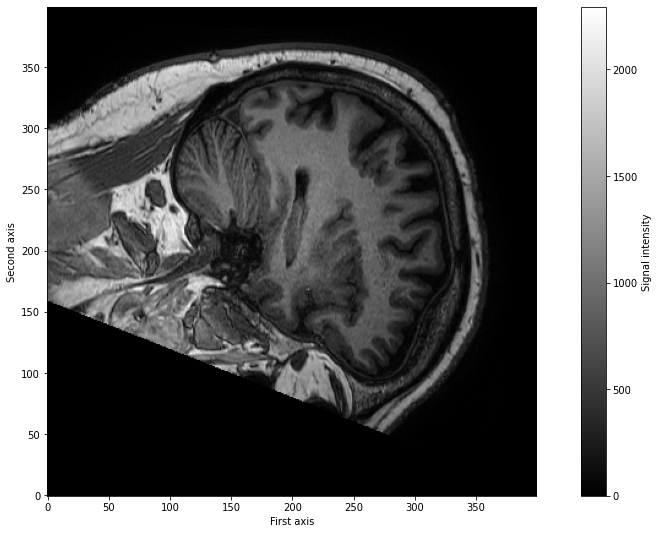

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
plt.imshow(data[:, :, 100], cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.show()

# SlowFast r101

In [ ]:
!pip install fvcore


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.1 MB/s 
     |████████████████████████████████| 42 kB 574 kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=97aafa0b5b76481f7279bcb1d555ea20dd4c84a3775bb90fdbf9aa3f786de752
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31549 sha256=8057209ced6ee086cc34de3df27bd7baec6b68a2ceb30acb3b5a4ce2bd3f5e66
  Stored in directory: /root/.cache/pip/wheels/aa/cc/ed/ca4e88beef656b01c84b9185196513ef2faf74a5a379b043a7
Successfully built fvcore iopath


In [ ]:
import torch
import torch.fx
import fvcore
model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r101', pretrained=True)

In [ ]:
from typing import Dict
import json
import urllib
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
) 

In [ ]:
torch.cuda.is_available()

In [ ]:
# Set to GPU or CPU
device = "cuda"
model = model.eval()
model = model.to(device)

NameError: ignored

In [ ]:
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 2
frames_per_second = 30
slowfast_alpha = 4
num_clips = 10
num_crops = 3

class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors. 
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // slowfast_alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
            PackPathway()
        ]
    ),
)

# The duration of the input clip is also specific to the model.
clip_duration = (num_frames * sampling_rate)/frames_per_second

NameError: ignored

In [ ]:
url_link = "https://www.youtube.com/watch?v=KfXFWq0C_4o"
video_path = 'pippi_on_the_run.mp4'
try: urllib.URLopener().retrieve(url_link, video_path)
except: urllib.request.urlretrieve(url_link, video_path)

NameError: ignored

In [ ]:
# Select the duration of the clip to load by specifying the start and end duration
# The start_sec should correspond to where the action occurs in the video
start_sec = 0
end_sec = start_sec + clip_duration

# Initialize an EncodedVideo helper class and load the video
video = EncodedVideo.from_path(video_path)

# Load the desired clip
video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)

# Apply a transform to normalize the video input
video_data = transform(video_data)

# Move the inputs to the desired device
inputs = video_data["video"]
inputs = [i.to(device)[None, ...] for i in inputs]

NameError: ignored

In [ ]:
preds = model(inputs)
print(preds)

## VTN

In [ ]:
!pip install simplejson
!pip install iopath
!pip install fvcore
!pip install timm
!pip install transformers

In [ ]:
import torch
from transformers import LongformerModel, LongformerConfig
import torch.nn.functional as F


class VTNLongformerModel(LongformerModel):

    def __init__(self,
                 embed_dim=768,
                 max_position_embeddings=2 * 60 * 60,
                 num_attention_heads=12,
                 num_hidden_layers=3,
                 attention_mode='sliding_chunks',
                 pad_token_id=-1,
                 attention_window=None,
                 intermediate_size=3072,
                 attention_probs_dropout_prob=0.1,
                 hidden_dropout_prob=0.1):

        self.config = LongformerConfig()
        self.config.attention_mode = attention_mode
        self.config.intermediate_size = intermediate_size
        self.config.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.config.hidden_dropout_prob = hidden_dropout_prob
        self.config.attention_dilation = [1, ] * num_hidden_layers
        self.config.attention_window = [256, ] * num_hidden_layers if attention_window is None else attention_window
        self.config.num_hidden_layers = num_hidden_layers
        self.config.num_attention_heads = num_attention_heads
        self.config.pad_token_id = pad_token_id
        self.config.max_position_embeddings = max_position_embeddings
        self.config.hidden_size = embed_dim
        super(VTNLongformerModel, self).__init__(self.config, add_pooling_layer=False)
        self.embeddings.word_embeddings = None  # to avoid distributed error of unused parameters


def pad_to_window_size_local(input_ids: torch.Tensor, attention_mask: torch.Tensor, position_ids: torch.Tensor,
                             one_sided_window_size: int, pad_token_id: int):
    '''A helper function to pad tokens and mask to work with the sliding_chunks implementation of Longformer self-attention.
    Based on _pad_to_window_size from https://github.com/huggingface/transformers:
    https://github.com/huggingface/transformers/blob/71bdc076dd4ba2f3264283d4bc8617755206dccd/src/transformers/models/longformer/modeling_longformer.py#L1516
    Input:
        input_ids = torch.Tensor(bsz x seqlen): ids of wordpieces
        attention_mask = torch.Tensor(bsz x seqlen): attention mask
        one_sided_window_size = int: window size on one side of each token
        pad_token_id = int: tokenizer.pad_token_id
    Returns
        (input_ids, attention_mask) padded to length divisible by 2 * one_sided_window_size
    '''
    w = 2 * one_sided_window_size
    seqlen = input_ids.size(1)
    padding_len = (w - seqlen % w) % w
    input_ids = F.pad(input_ids.permute(0, 2, 1), (0, padding_len), value=pad_token_id).permute(0, 2, 1)
    attention_mask = F.pad(attention_mask, (0, padding_len), value=False)  # no attention on the padding tokens
    position_ids = F.pad(position_ids, (1, padding_len), value=False)  # no attention on the padding tokens
    return input_ids, attention_mask, position_ids


In [ ]:
from fvcore.common.registry import Registry

MODEL_REGISTRY = Registry("MODEL")
MODEL_REGISTRY.__doc__ = """
Registry for video model.

The registered object will be called with `obj(cfg)`.
The call should return a `torch.nn.Module` object.
"""


def build_model(cfg, gpu_id=None):
    """
    Builds the video model.
    Args:
        cfg (configs): configs that contains the hyper-parameters to build the
        backbone. Details can be seen in slowfast/config/defaults.py.
        gpu_id (Optional[int]): specify the gpu index to build model.
    """
    if torch.cuda.is_available():
        assert (
            cfg.NUM_GPUS <= torch.cuda.device_count()
        ), "Cannot use more GPU devices than available"
    else:
        assert (
            cfg.NUM_GPUS == 0
        ), "Cuda is not available. Please set `NUM_GPUS: 0 for running on CPUs."

    # Construct the model
    name = cfg.MODEL.MODEL_NAME
    model = MODEL_REGISTRY.get(name)(cfg)

    if cfg.NUM_GPUS:
        if gpu_id is None:
            # Determine the GPU used by the current process
            cur_device = torch.cuda.current_device()
        else:
            cur_device = gpu_id
        # Transfer the model to the current GPU device
        model = model.cuda(device=cur_device)
    # Use multi-process data parallel model in the multi-gpu setting
    if cfg.NUM_GPUS > 1:
        # Make model replica operate on the current device
        model = torch.nn.parallel.DistributedDataParallel(
            module=model, device_ids=[cur_device], output_device=cur_device
        )
    return model

In [ ]:
#!/usr/bin/env python3
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved.

"""Video models."""

import math
import torch
import torch.nn as nn
from timm.models.vision_transformer import vit_base_patch16_224

@MODEL_REGISTRY.register()
class VTN(nn.Module):
    """
    VTN model builder. It uses ViT-Base as the backbone.

    Daniel Neimark, Omri Bar, Maya Zohar and Dotan Asselmann.
    "Video Transformer Network."
    https://arxiv.org/abs/2102.00719
    """

    def __init__(self, cfg):
        """
        The `__init__` method of any subclass should also contain these
            arguments.
        Args:
            cfg (CfgNode): model building configs, details are in the
                comments of the config file.
        """
        super(VTN, self).__init__()
        self._construct_network(cfg)

    def _construct_network(self, cfg):
        """
        Builds a VTN model, with a given backbone architecture.
        Args:
            cfg (CfgNode): model building configs, details are in the
                comments of the config file.
        """
        if cfg.MODEL.ARCH == "VIT":
            self.backbone = vit_base_patch16_224(pretrained=cfg.VTN.PRETRAINED,
                                                 num_classes=0,
                                                 drop_path_rate=cfg.VTN.DROP_PATH_RATE,
                                                 drop_rate=cfg.VTN.DROP_RATE)
        else:
            raise NotImplementedError(f"not supporting {cfg.MODEL.ARCH}")

        embed_dim = self.backbone.embed_dim
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        self.temporal_encoder = VTNLongformerModel(
            embed_dim=embed_dim,
            max_position_embeddings=cfg.VTN.MAX_POSITION_EMBEDDINGS,
            num_attention_heads=cfg.VTN.NUM_ATTENTION_HEADS,
            num_hidden_layers=cfg.VTN.NUM_HIDDEN_LAYERS,
            attention_mode=cfg.VTN.ATTENTION_MODE,
            pad_token_id=cfg.VTN.PAD_TOKEN_ID,
            attention_window=cfg.VTN.ATTENTION_WINDOW,
            intermediate_size=cfg.VTN.INTERMEDIATE_SIZE,
            attention_probs_dropout_prob=cfg.VTN.ATTENTION_PROBS_DROPOUT_PROB,
            hidden_dropout_prob=cfg.VTN.HIDDEN_DROPOUT_PROB)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(cfg.VTN.HIDDEN_DIM),
            nn.Linear(cfg.VTN.HIDDEN_DIM, cfg.VTN.MLP_DIM),
            nn.GELU(),
            nn.Dropout(cfg.MODEL.DROPOUT_RATE),
            nn.Linear(cfg.VTN.MLP_DIM, cfg.MODEL.NUM_CLASSES)
        )

    def forward(self, x, bboxes=None):

        x, position_ids = x

        # spatial backbone
        B, F, C, H, W = x.shape
        x = x.reshape(B * F, C, H, W)
        x = self.backbone(x)
        x = x.reshape(B, F, -1)

        # temporal encoder (Longformer)
        B, D, E = x.shape
        attention_mask = torch.ones((B, D), dtype=torch.long, device=x.device)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        cls_atten = torch.ones(1).expand(B, -1).to(x.device)
        attention_mask = torch.cat((attention_mask, cls_atten), dim=1)
        attention_mask[:, 0] = 2
        x, attention_mask, position_ids = pad_to_window_size_local(
            x,
            attention_mask,
            position_ids,
            self.temporal_encoder.config.attention_window[0],
            self.temporal_encoder.config.pad_token_id)
        token_type_ids = torch.zeros(x.size()[:-1], dtype=torch.long, device=x.device)
        token_type_ids[:, 0] = 1

        # position_ids
        position_ids = position_ids.long()
        mask = attention_mask.ne(0).int()
        max_position_embeddings = self.temporal_encoder.config.max_position_embeddings
        position_ids = position_ids % (max_position_embeddings - 2)
        position_ids[:, 0] = max_position_embeddings - 2
        position_ids[mask == 0] = max_position_embeddings - 1

        x = self.temporal_encoder(input_ids=None,
                                  attention_mask=attention_mask,
                                  token_type_ids=token_type_ids,
                                  position_ids=position_ids,
                                  inputs_embeds=x,
                                  output_attentions=None,
                                  output_hidden_states=None,
                                  return_dict=None)
        # MLP head
        x = x["last_hidden_state"]
        x = self.mlp_head(x)
        return x


In [ ]:
!unzip config.zip #SlowFast/slowfast/config

In [ ]:
from config.defaults import get_cfg

In [ ]:
cfg = get_cfg()
cfg.merge_from_file("VIT_B_VTN.yaml") #SlowFast/configs/Kinetics/VIT_B_VTN.yaml
model = build_model(cfg)

In [ ]:
!wget https://researchpublic.blob.core.windows.net/vtn/VTN_VIT_B_KINETICS.pyth

In [ ]:
state_dict = torch.load('VTN_VIT_B_KINETICS.pyth')['model_state']
state_dict.pop('temporal_encoder.embeddings.position_ids')
model.load_state_dict(state_dict)

In [ ]:
video_batch = video.unsqueeze(0)
position_idx_batch = position_idx.unsqueeze(0)

In [ ]:
output = model((video_batch, position_idx_batch))

In [ ]:
output.shape

In [ ]:
import matplotlib.pyplot as plt
for i in range(1, 17):
  plt.plot(torch.softmax(output[0, i], 0).detach().numpy(), alpha=0.2)

In [ ]:
torch.argmax(output[0, 0]) #https://gist.github.com/willprice/f19da185c9c5f32847134b87c1960769

In [ ]:
plt.imshow(video[0].permute(1, 2, 0).detach().numpy())